This Notebook lives at [Github](https://github.com/petermchale/yeast_bioinformatics). Follow [these instructions](http://jupyter.readthedocs.io/en/latest/install.html) to execute the Notebook using Python 3.x.  Otherwise, [view this Notebook](http://nbviewer.jupyter.org/github/petermchale/yeast_bioinformatics/blob/master/analysis.ipynb) in read-only mode using [Jupyter Notebook Viewer](http://nbviewer.jupyter.org/).

# Transcription Factor-DNA binding in yeast

Written by [Peter McHale](http://ccbs-76.bio.uci.edu/~petermchale/). 

The eukaryotic genome is adorned by molecules called transcription factors (TFs) that bind a small number of target promoters to regulate gene transcription. But do they also bind other genomic locations that do not directly influence transcription rates? To approach this question, we first need to quantify the strength with which TFs bind DNA. Denote by $E(\vec{s})$ the binding energy of a TF to a sequence 

\begin{equation} 
\vec{s} = \langle s_1, s_2, \ldots, s_L\rangle
\end{equation} 

of $L$ nucleotides $s_i \in \{A,C,G,T\}$. With binding lengths of $L = 10-20$ nucleotides, the number of possible sequences is too large to measure individually. Fortunately, the contribution of each nucleotide to the binding energy of the parent sequence is approximately independent and additive: 

\begin{equation} 
E(\vec{s}) = \sum_{i=1}^L \epsilon_i(s_i),
\end{equation}

reducing the impractical problem of determining the large number of values of $E(\vec{s})$ to the practical problem of the determining the 
 $L\times 4$ energy matrix, $\epsilon_i(s)$. This matrix has been determined experimentally for Gal4 by *in vitro* measurements of the equilibrium binding constants 
 
\begin{equation} 
K(\vec{s}) \propto e^{-\beta E(\vec{s})} 
\end{equation} 

for all sequences $\vec{s}$ that differ in just one nucleotide from a given sequence [[Liang et al 1996](https://www.ncbi.nlm.nih.gov/pubmed/8668194)]. I used the energy matrix of Gal4 to compute the energy with which it binds each possible sequence in a yeast chromosome:

In [1]:
%cd data
%pwd
!python ../source/binChr03_gal4.py

/Users/ccbs/Desktop/yeast_bioinformatics/data
evaluating energy list ...
...energy list evaluated
binning energies...
...energies binned


Now let's analyze the results:

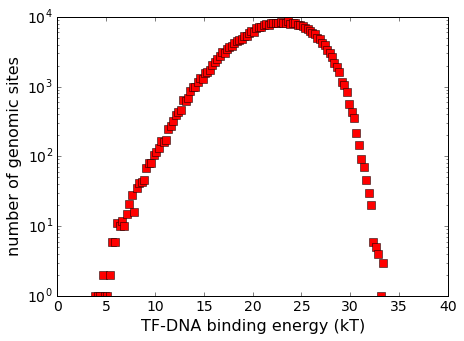

In [2]:
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

fontsize = 16
fontsize_tick = 14

numberSites_bindingEnergies = np.loadtxt('binChr03_Gal4_0.25_.dat')
numberSites = numberSites_bindingEnergies[:,0]
bindingEnergies = numberSites_bindingEnergies[:,1]

fig = plt.figure(figsize=(7,5), facecolor='w')
ax = fig.add_subplot(111)
ax.plot(numberSites, bindingEnergies, linewidth=0, marker='s', markersize=8, color='red')
ax.set_xlabel('TF-DNA binding energy (kT)', fontsize=fontsize)
ax.set_ylabel('number of genomic sites', fontsize=fontsize)
ax.set_yscale('log')
ax.set_xlim(0, 40)
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)

Though highly-specific (low-energy) sites do indeed exist, the sheer number of less-specific (intermediate- to high-energy) sites across the genome can, in principle, soak up a significant number of TFs. Weak-binding at non-consensus genomic locations has been hypothesized to influence nucleosome positioning, as I discuss next... 

## Nucleosome positioning

DNA in eukaryotic cells is wrapped around protein cores called nucleosomes. This packaging of DNA plays a crucial role in the regulation of gene expression and other DNA-related processes. 

The positioning of nucleosomes in yeast relative to its underlying genomic sequence has been computed by [Yuan et al 2005](https://www.ncbi.nlm.nih.gov/pubmed/15961632) using a tiled microarray approach, and is reproduced here in the input files
```
randoProbeInfo.in
randoHMMhandCalls.in
```
I used that data, together with the DNA sequence of a yeast chromosome, contained in the [FASTA format](https://en.wikipedia.org/wiki/FASTA_format) file 
```
chr03.fsa,
```
to compute *linker DNA*: the sequence lying between consecutive nucleosomes. I then extracted coding sequences from the [General Feature Format](https://en.wikipedia.org/wiki/General_feature_format) file 
```
saccharomyces_cerevisiae_chr03.gff
``` 
and used them to find promoter regions lying upstream of start codons. Finally, a list of all linker lengths, and of those located immediately upstream of coding sequences, was computed. 

In [3]:
!python ../source/concatenateRandoData.py
!python ../source/findLinkersFromRando.py
!python ../source/filterRandoData.py

max linker length = 990
max length on histogram = 1000
chr03 length = 316617
# promoter linkers = 112


Now let's analyze the results...'

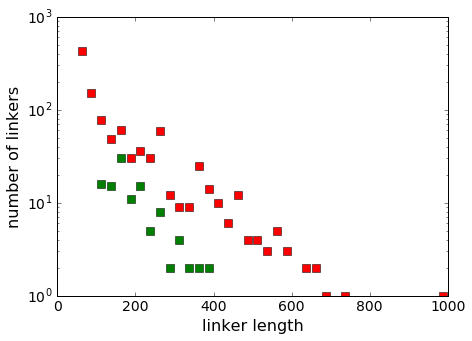

In [4]:
fig = plt.figure(figsize=(7,5), facecolor='w')
ax = fig.add_subplot(111)

def plot_histogram_linker_lengths(filename, color):
    
    allLinkerLengths = np.loadtxt(filename)
    bin_width = 25
    x_max = max(allLinkerLengths) + 2*bin_width    
    bin_edges = np.arange(0, x_max, bin_width)
    counts = np.histogram(allLinkerLengths, bin_edges)[0]
    counts = np.array(counts)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    ax.plot(bin_centers, counts, linewidth=0, marker='s', markersize=8, color=color)
    
plot_histogram_linker_lengths('allLinkerLengths.dat', 'red') 
plot_histogram_linker_lengths('promoterLinkerLengths.dat', 'green') 

ax.set_xlabel('linker length', fontsize=fontsize)
ax.set_ylabel('number of linkers', fontsize=fontsize)
ax.set_yscale('log')
ax.set_xlim(0, 1000)
ax.set_ylim(1e0, 1e3)
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)

The distribution of all DNA linker lengths (red), and of those that lie within promoter regions (green), appears to be close to random, i.e. the data appear to be exponentially distributed as  predicted by a Poisson process. 

More interesting is the absence of short linkers in promoter regions (green), implying that yeast promoters are characterized by a nucleosome-free region (NFR) of about 140 bp upstream of the start codon  [[Yuan et al 2005](https://www.ncbi.nlm.nih.gov/pubmed/15961632)]. 

It has been hypothesized that NFRs are caused by the weak TF-DNA binding described above. The idea is that TFs sometimes beat nucleosomes in the competition for genomic binding sites, not just in yeast [[Afek et al 2011](https://www.ncbi.nlm.nih.gov/pubmed/?term=Nonspecific+Transcription-Factor-DNA+Binding+Influences+Nucleosome+Occupancy+in+Yeast)] but also in higher eukaryotic genomes [[Afek et al 2015](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004429)], as illustrated in the following cartoon:

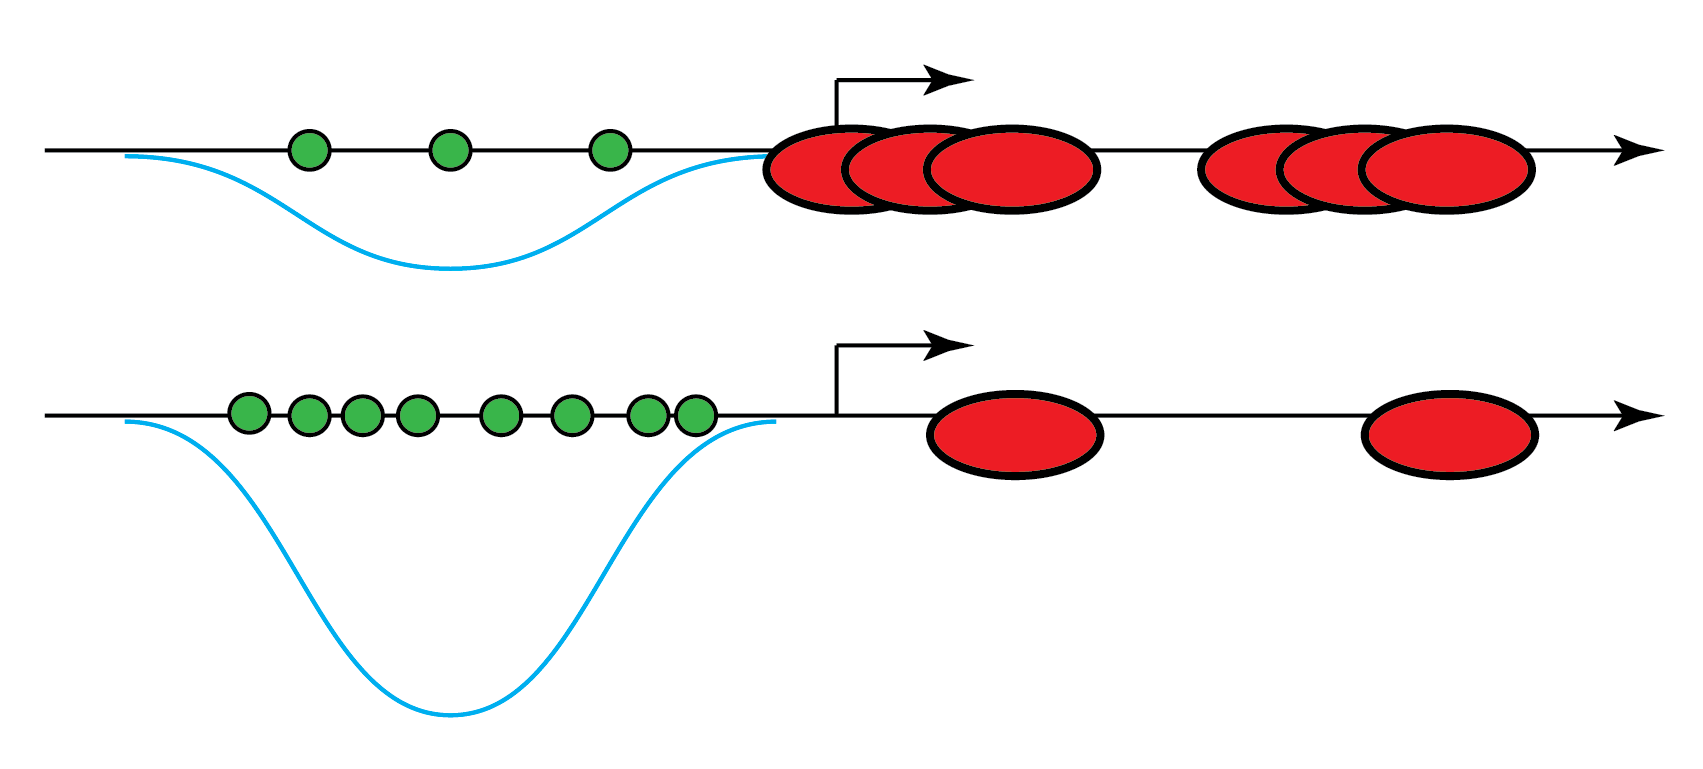

In [5]:
from IPython.display import Image
Image(filename="../images/TF_nucleosome_positioning.png", width=400)

This is a schematic representation of [Afek et al's](https://www.ncbi.nlm.nih.gov/pubmed/?term=Nonspecific+Transcription-Factor-DNA+Binding+Influences+Nucleosome+Occupancy+in+Yeast) hypothesized mechanism for statistical nucleosome positioning by nonspecifically bound TFs. Nucleosomes are represented as large, red ovals and transcription factor molecules as small, green circles. The free-energy landscape of nonspecific TF-DNA binding (blue curves) leads to weak (upper) and strong (lower) attraction of TFs, respectively. In the former case, the barrier for nucleosome positioning is weak (nucleosomes are not well localized); whereas in the latter case, the barrier is strong (well localized, periodically ordered nucleosomes).